Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  48.6 s
2: Total numb steps is  1213


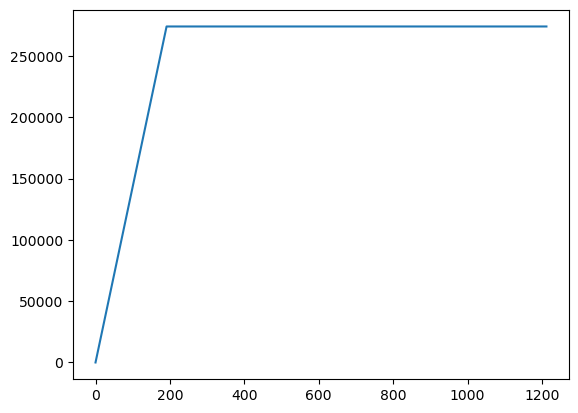

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 112
v_vehicle = 160
c_acc = 1

# calling local functions to get all parameters
(
    dt,
    P,
    g,
    num_steps,
    h,
    radiation,
    v_angular,
    Ti,
    Tm,
    S_rub_circle,
    t,
    rho,
    c,
    k,
    t_brake,
    S_total,
) = vehicle_initial(angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)
plt.plot(P)

In [3]:
print(h,k,radiation,)

7.75e-05 0.048 3.6287999999999996e-13


## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u_n), grad(v)) * dx
    + h * inner(u_n, v) * ds(200)
    + radiation * inner(u_n**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    # before 2024/5/16
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u_n, v) * ds(10 * i)  
          - radiation * inner( (u_n**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-05-23 11:04:51.498 (  14.576s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:51.605 (  14.682s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:51.641 (  14.717s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00985823 (tol = 1e-10) r (rel) = 1.58461e-06(tol = 1e-06)
2024-05-23 11:04:51.664 (  14.741s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:51.698 (  14.774s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.74335e-08 (tol = 1e-10) r (rel) = 7.62444e-12(tol = 1e-06)
2024-05-23 11:04:51.698 (  14.775s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


## 5: Solution


In [ ]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u_n), grad(v)) * dx
        + h * inner(u_n, v) * ds(200)
        + radiation * inner(u_n**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u_n, v) * ds(10 * j)  
          - radiation * inner( (u_n**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 112 degree. 2: Current time is 0.0 s. 3: Completion is 0.0 %. 

2024-05-23 11:04:55.037 (  18.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:55.038 (  18.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:55.039 (  18.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:04:55.039 (  18.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:55.040 (  18.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:55.040 (  18.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:04:55.040 (  18.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:55.041 (  18.117s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.0 %. 

2024-05-23 11:04:56.005 (  19.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 11:04:56.006 (  19.083s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 11:04:56.030 (  19.106s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 11:04:56.062 (  19.138s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:56.229 (  19.306s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:56.263 (  19.340s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.11534e-06 (tol = 1e-10) r (rel) = 5.03299e-06(tol = 1e-06)
2024-05-23 11:04:56.284 (  19.361s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:04:56.306 (

1: Rotation has applied for 224 degree. 2: Current time is 0.0 s. 3: Completion is 0.1 %. 

2024-05-23 11:04:56.541 (  19.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:56.541 (  19.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:56.541 (  19.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:04:56.541 (  19.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:56.541 (  19.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:56.541 (  19.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:04:56.542 (  19.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:04:56.542 (  19.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.1 %. 

2024-05-23 11:05:06.733 (  29.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 11:05:06.733 (  29.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 11:05:06.747 (  29.824s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 11:05:06.778 (  29.855s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:06.877 (  29.953s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:06.898 (  29.975s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.19108e-06 (tol = 1e-10) r (rel) = 5.24982e-06(tol = 1e-06)
2024-05-23 11:05:06.925 (  30.002s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 336 degree. 2: Current time is 0.1 s. 3: Completion is 0.1 %. 

2024-05-23 11:05:06.950 (  30.028s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.04216e-11 (tol = 1e-10) r (rel) = 3.35967e-11(tol = 1e-06)
2024-05-23 11:05:06.952 (  30.028s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 11:05:06.952 (  30.028s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 11:05:07.016 (  30.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:07.017 (  30.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:07.017 (  30.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:05:07.017 (  30.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 0.1 %. 

2024-05-23 11:05:16.584 (  39.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 11:05:16.585 (  39.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 11:05:16.599 (  39.676s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 11:05:16.622 (  39.699s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:16.674 (  39.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:16.702 (  39.783s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 8.7287e-06 (tol = 1e-10) r (rel) = 4.85654e-06(tol = 1e-06)
2024-05-23 11:05:16.717 (  39.794s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:16.748 ( 

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-05-23 11:05:16.847 (  39.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:16.848 (  39.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:16.848 (  39.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:05:16.848 (  39.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:16.848 (  39.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:16.849 (  39.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 11:05:16.849 (  39.925s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:16.849 (  39.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.2 %. 

2024-05-23 11:05:32.155 (  55.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 11:05:32.155 (  55.231s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 11:05:32.171 (  55.248s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 11:05:32.198 (  55.274s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:32.311 (  55.387s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:32.373 (  55.455s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 8.75277e-06 (tol = 1e-10) r (rel) = 5.26147e-06(tol = 1e-06)


1: Rotation has applied for 560 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-05-23 11:05:32.413 (  55.489s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:32.456 (  55.533s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.6945e-11 (tol = 1e-10) r (rel) = 3.42308e-11(tol = 1e-06)
2024-05-23 11:05:32.456 (  55.533s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 11:05:32.457 (  55.533s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 11:05:32.533 (  55.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:32.537 (  55.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 11:05:32.537 (  55.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 0.2 %. 

2024-05-23 11:05:43.406 (  66.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 11:05:43.406 (  66.482s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 11:05:43.430 (  66.507s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 11:05:43.457 (  66.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 672 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-05-23 11:05:43.941 (  67.018s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:43.967 (  67.044s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.13064e-05 (tol = 1e-10) r (rel) = 5.25592e-06(tol = 1e-06)
2024-05-23 11:05:43.986 (  67.066s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 11:05:44.006 (  67.086s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.38621e-11 (tol = 1e-10) r (rel) = 3.43357e-11(tol = 1e-06)
2024-05-23 11:05:44.010 (  67.086s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 11:05:44.010 (  67.087s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 11:05:44.093 (  67.169s) [main            ]topologycom

# 6: Post process

In [ ]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
print("Move files successfully")

In [ ]:
## get t and temperature T form T_array matrix
t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_max = []
for i in range(len(T)):
    T_max.append(max(T[i]))

plt.plot(t, T_max)

In [ ]:
from brake_disc_functions import *

lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [ ]:
print(mesh_filename1)

In [ ]:
lables = find_3_coord(mesh_filename1)
# T_3_labels = 333431, 308947, 18936   # 1-2 mesh
# for i in range(len(T)):
#   print( T[i][T_3_labels[1]] )